# 10/15/24: recognition phase plots
* As a reminder, 16 subjs across 29 session undergo 40-trial recognition phases, with 20 familiar & 20 novel images.  
* Subjs rate images from 1 (familiar, sure) to 6 (novel, sure).  

After wrangling all their data into 1 df, I plotted:  
1. Distribution of RTs  .
2. Rasters & PSTHs for example cells from each region. For the latter, I trimmed all trials to 5s.  
3. Distribution of avg FRs across trials (non-zero FRs only).  
4. Trial-avged FR for correct vs incorrect (note that these are imbalanced classes as printed above the plot).  
5. Trial-avged FR for (correct+high confidence) vs others (much better balanced).  


In [1]:
import warnings
warnings.filterwarnings("ignore")

import os, pandas as pd, matplotlib.pyplot as plt, numpy as np, seaborn as sns, scipy.stats as stats, glob
from pynwb import NWBHDF5IO
from pathlib import Path
from convnwb.io import load_nwbfile

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix


## check data

In [2]:
# norm_choice = 'shortest_baseline'
# norm_choice = 'session_baseline'
norm_choice = 'self'
# norm_choice = 'nothing'
print(f'df normalized by {norm_choice}\n')

df = pd.read_pickle(f'./data_files/neuron_by_trial_norm_by_{norm_choice}.pkl')
print(f'{df["neuron"].nunique()} total neurons\n')

# identify neurons with zero firing rate in encoding or baseline
zero_FR_neurons = df[(df['FR'] == 0) & (df['stim_phase'].isin(['encoding', 'baseline']))]['neuron'].unique().tolist()
print(f'{len(zero_FR_neurons)} neurons dropped because FR = 0 in encoding or baseline: {zero_FR_neurons}\n')

# identify the 48 neurons from the 1 session with <40 trials
neurs_with_miss_trials = df['neuron'].value_counts()[df['neuron'].value_counts() < 40].index.tolist()

# now filter
df_filtered = df[~df['neuron'].isin(zero_FR_neurons+neurs_with_miss_trials)]
df_recognition = df_filtered[df_filtered['stim_phase'] == 'recognition']

num_subjs, num_sess, num_neurons = len(np.unique(df_recognition['subj'])), len(np.unique(df_recognition['sess'])), len(np.unique(df_recognition['neuron']))

print(f'{num_neurons} neurons, {num_sess} sessions, {num_subjs} subjects')
print(f'{num_neurons*40} = {len(df_recognition)} rows in df\n')

no_fMRI_subjs = ['P49', 'P55', 'P56', 'P57', 'P58']
print(f'subjs who didnt undergo fMRI: {no_fMRI_subjs}\n')

scene_cells = ['P42CS_R1_47_2_1347_7', 'P42CS_R2_42_3_1096_7', 'P43CS_R1_59_3_1929_1', 'P43CS_R1_76_4_1276_10', 'P43CS_R2_29_1_2303_2',
               'P44CS_R1_15_2_835_8', 'P47CS_R1_10_2_900_8', 'P47CS_R1_18_1_1631_4', 'P47CS_R1_22_4_1379_4', 'P47CS_R1_68_1_964_9',
               'P47CS_R1_74_2_1575_10', 'P47CS_R1_78_1_2233_10', 'P47CS_R2_19_2_3139_4', 'P47CS_R2_20_4_2437_4', 'P47CS_R2_47_1_1478_7',
               'P48CS_R1_9_1_678_8', 'P48CS_R1_21_2_873_4', 'P48CS_R1_30_1_1720_2', 'P48CS_R1_43_2_3181_7', 'P48CS_R2_48_2_936_7',
               'P48CS_R2_58_8_6571_1', 'P49CS_R1_7_1_2581_6', 'P49CS_R2_67_1_1165_10', 'P51CS_R1_48_1_2072_8', 'P51CS_R2_40_3_2542_5',
               'P51CS_R2_80_1_794_9', 'P53CS_R1_10_1_2456_8', 'P53CS_R2_6_4_5480_6', 'P53CS_R2_16_2_6444_8', 'P54CS_R1_17_2_3943_4',
               'P54CS_R1_45_1_2172_7', 'P54CS_R1_54_3_4177_3', 'P54CS_R1_55_2_6861_3', 'P54CS_R1_56_1_1540_3', 'P54CS_R1_70_3_5181_10',
               'P54CS_R2_13_4_7736_8', 'P54CS_R2_67_1_4703_10', 'P55CS_R2_18_2_1050_4', 'P55CS_R2_45_1_1206_7', 'P55CS_R2_48_1_36_7',
               'P56CS_R1_9_1_3423_8', 'P56CS_R1_13_1_999_8', 'P56CS_R1_19_1_1458_4', 'P57CS_R1_66_1_2442_10', 'P57CS_R2_9_1_740_8',
               'P57CS_R2_15_2_1738_8', 'P57CS_R2_70_2_1978_10', 'P58CS_R1_34_3_3299_5', 'P58CS_R1_34_4_3301_5', 'P58CS_R1_35_4_2476_5',
               'P58CS_R1_56_1_3134_3', 'P58CS_R1_57_3_2783_1', 'P58CS_R1_60_1_1424_1', 'P58CS_R1_62_2_3305_1', 'P58CS_R1_63_2_3170_1',
               'P60CS_R1_39_1_1408_5', 'P60CS_R1_54_1_571_3', 'P60CS_R1_56_1_1106_3', 'P62CS_R1_30_3_6240_3', 'P62CS_R2_22_2_2532_7']

sessions_with_scene_cells = np.unique([cell[:8] for cell in scene_cells])
print(f'{len(sessions_with_scene_cells)} sessions with scene cells: {sessions_with_scene_cells}\n')
print(f'{len(scene_cells)} scene selective cells')

df_recognition.head()


df normalized by self

1457 total neurons

19 neurons dropped because FR = 0 in encoding or baseline: ['P43CS_R2_76_1_990_10', 'P47CS_R1_19_4_1280_4', 'P47CS_R1_52_1_298_3', 'P47CS_R2_22_1_8375_4', 'P48CS_R1_24_1_2297_4', 'P48CS_R1_57_1_753_1', 'P48CS_R2_58_3_6420_1', 'P48CS_R2_62_2_2097_1', 'P49CS_R2_64_1_4257_1', 'P51CS_R2_48_4_5337_7', 'P53CS_R1_37_1_3731_5', 'P54CS_R1_70_2_5145_10', 'P54CS_R2_31_1_2534_2', 'P55CS_R1_49_2_5469_3', 'P55CS_R1_54_1_3978_3', 'P57CS_R2_51_1_624_3', 'P62CS_R1_27_3_8498_3', 'P62CS_R1_29_3_8468_3', 'P62CS_R1_32_6_6115_3']

1390 neurons, 28 sessions, 16 subjects
55600 = 55600 rows in df

subjs who didnt undergo fMRI: ['P49', 'P55', 'P56', 'P57', 'P58']

25 sessions with scene cells: ['P42CS_R1' 'P42CS_R2' 'P43CS_R1' 'P43CS_R2' 'P44CS_R1' 'P47CS_R1'
 'P47CS_R2' 'P48CS_R1' 'P48CS_R2' 'P49CS_R1' 'P49CS_R2' 'P51CS_R1'
 'P51CS_R2' 'P53CS_R1' 'P53CS_R2' 'P54CS_R1' 'P54CS_R2' 'P55CS_R2'
 'P56CS_R1' 'P57CS_R1' 'P57CS_R2' 'P58CS_R1' 'P60CS_R1' 'P62CS_R1'
 'P62CS_R2']

,subj,sess,neuron,region,start_time,stop_time,RT,trial_spikes,trial_aligned_spikes,num_spikes,FR,trial_smooth_spikes,trial_smooth_FR,stim_phase,stimulus_file,response_correct,response_confidence,actual_response
2,P41,P41CS_R1,P41CS_R1_21_1_679_4,amygdala,566.346460,577.078362,10.731902,"[566.79785075, 568.845881, 569.40153725, 576.0...","[0.4513907499999732, 2.499420999999984, 3.0550...",4,0.372721,"[1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.040230,recognition,old015.png,1.0,2.0,5.0
3,P41,P41CS_R1,P41CS_R1_21_1_679_4,amygdala,578.122799,582.712578,4.589779,[582.05028225],[3.927483250000023],1,0.217875,"[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...",0.011494,recognition,new021.png,1.0,3.0,1.0
4,P41,P41CS_R1,P41CS_R1_21_1_679_4,amygdala,583.755203,591.685106,7.929903,[589.2551855],[5.499982499999987],1,0.126105,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ...",0.011494,recognition,new030.png,0.0,3.0,6.0
5,P41,P41CS_R1,P41CS_R1_21_1_679_4,amygdala,592.728012,597.998541,5.270529,"[593.583746, 593.7849335]","[0.855733999999984, 1.0569214999999303]",2,0.379469,"[1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.022989,recognition,old012.png,0.0,3.0,1.0
6,P41,P41CS_R1,P41CS_R1_21_1_679_4,amygdala,599.050103,603.022414,3.972311,"[599.334119, 600.3696805, 600.79902425, 602.03...","[0.2840159999999514, 1.319577499999923, 1.7489...",4,1.006971,"[1, 1, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.040230,recognition,old021.png,1.0,3.0,6.0


## RT distribution & outlier sessions

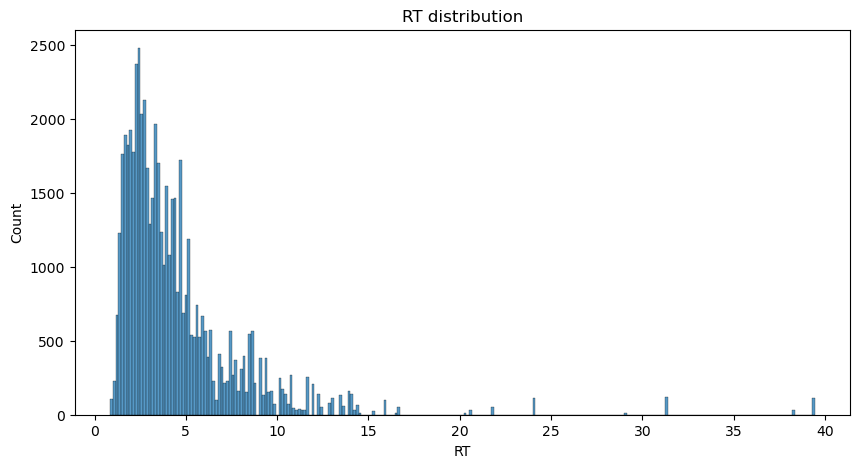

In [3]:
plt.figure(figsize=(10,5))
sns.histplot(df_recognition['RT'])
plt.title('RT distribution')
plt.show()

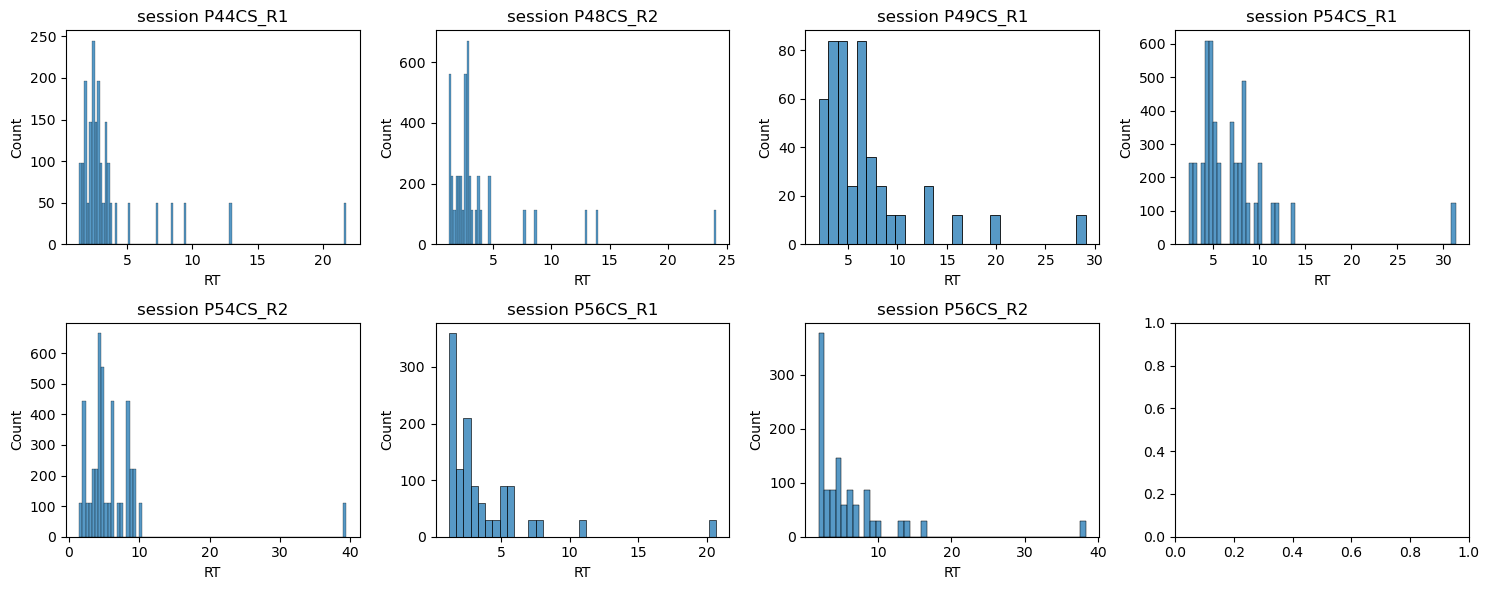

In [4]:
high_RT_df = df_recognition[df_recognition['RT'] > 20]
high_RT_sess_df = high_RT_df.groupby('sess').first().reset_index()
high_RT_sess = ['P44CS_R1', 'P48CS_R2', 'P49CS_R1', 'P54CS_R1', 'P54CS_R2', 'P56CS_R1', 'P56CS_R2']

fig, axs = plt.subplots(2, 4, figsize=(15,6))
axs, ax_count = axs.flatten(), 0

for sess_id, sess_df in df_recognition.groupby('sess'):
    
    if sess_id in high_RT_sess:

        sns.histplot(sess_df['RT'], ax=axs[ax_count])
        axs[ax_count].set_title(f'session {sess_id}')
        ax_count+=1

plt.tight_layout()
plt.show()


### example cell raster & PSTH by region

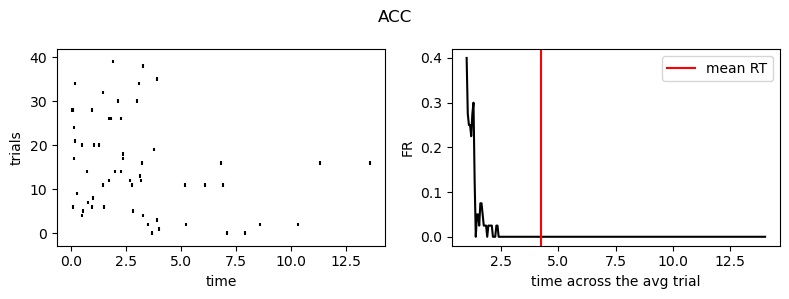

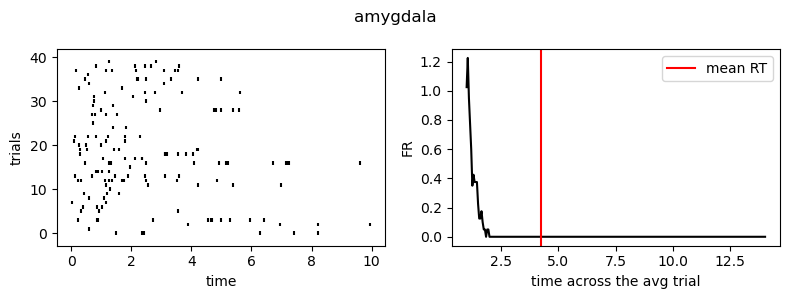

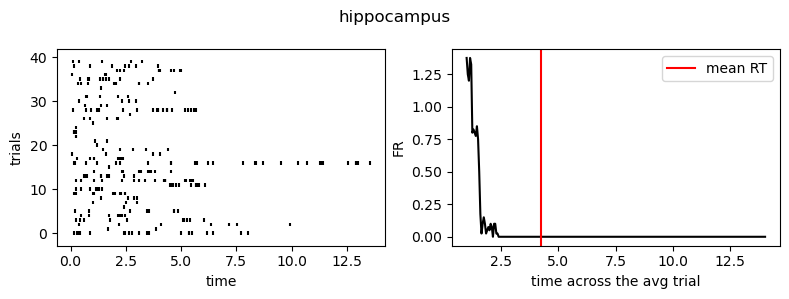

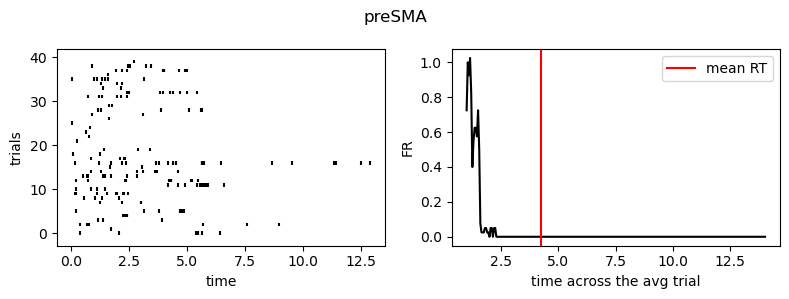

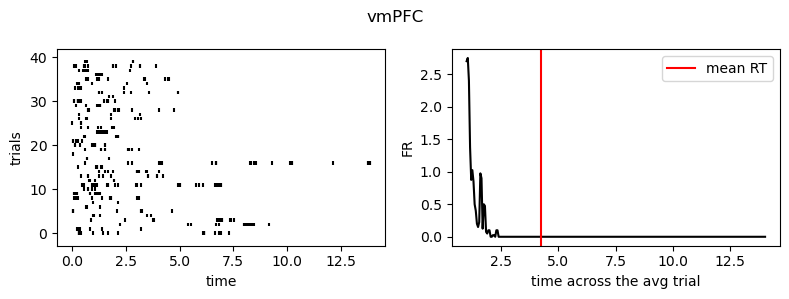

In [5]:
sess_num = 0

for session, session_df in df_recognition.groupby('sess'):

    # if this session does not have recordings from all 5 regions, continue to next session
    if not len(np.unique(session_df['region'])) == 5:
        continue
    
    sess_num += 1
    if sess_num < 1: # can be used to pick specific session
        continue

    for region, region_df in session_df.groupby('region'):

        neuron_num = 0

        fig, ax = plt.subplots(1, 2, figsize=(8, 3))
        fig.suptitle(region)

        for neuron, neuron_df in region_df.groupby('neuron'):
            
            neuron_num += 1
            if neuron_num < 1: # can be used to pick specific neuron
                continue
                
            # RASTER

            ax[0].eventplot(neuron_df['trial_aligned_spikes'], linelengths=0.8, color='black')
            ax[0].set_ylabel('trials')
            ax[0].set_xlabel('time')


            # SMOOTHED FR

            num_bins = len(neuron_df['trial_smooth_spikes'].iloc[0])
            x_time_points = np.linspace(1, np.max(neuron_df['RT']), num_bins)
            
            # convert df of lists to np array to be able to calculate mean
            trial_smooth_spikes_arr = np.array(neuron_df['trial_smooth_spikes'].tolist())
            
            ax[1].plot(x_time_points, np.mean(trial_smooth_spikes_arr, axis=0), color='black')
            ax[1].axvline(np.mean(neuron_df['RT']), color='red', label='mean RT')

            ax[1].set_ylabel('FR')
            ax[1].set_xlabel('time across the avg trial')

            break
        
        plt.legend()
        plt.tight_layout()
        plt.show()

    break


### discard outliers with extreme FRs

num_neurons * num_trials 55600
num_neurons * num_trials after outlier removal: 46737


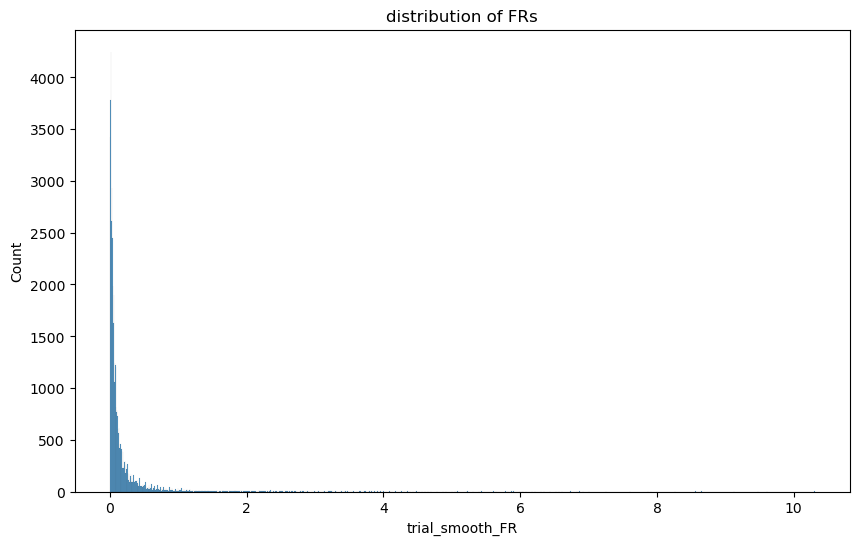

In [6]:
print(f'num_neurons * num_trials {len(df_recognition)}')

df_recognition = df_recognition[df_recognition['FR'] != 0]
print(f'num_neurons * num_trials after outlier removal: {len(df_recognition)}')

plt.figure(figsize=(10,6))
sns.histplot(df_recognition['trial_smooth_FR'])
plt.title('distribution of FRs')
plt.show()

### correct vs incorrect

response_correct
0.0    11640
1.0    35097
dtype: int64


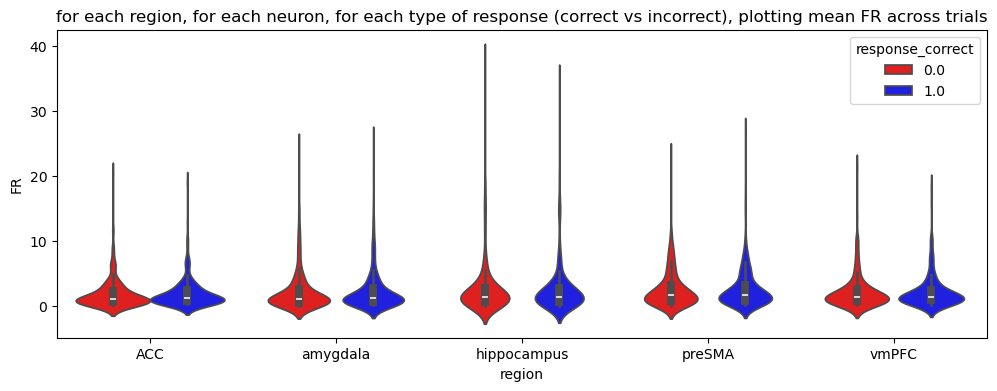

In [7]:
print(df_recognition.groupby(['response_correct']).size())

correctness_fr = df_recognition.groupby(['region', 'neuron', 'response_correct'])['FR'].mean().reset_index()
plt.figure(figsize=(12, 4))
sns.violinplot(correctness_fr, x='region', y='FR', hue='response_correct', palette=['red', 'blue'])
plt.title('for each region, for each neuron, for each type of response (correct vs incorrect), plotting mean FR across trials')
plt.show()


### (confident + correct) vs not

conf_corr
Confident & Correct    23537
Other                  23200
dtype: int64


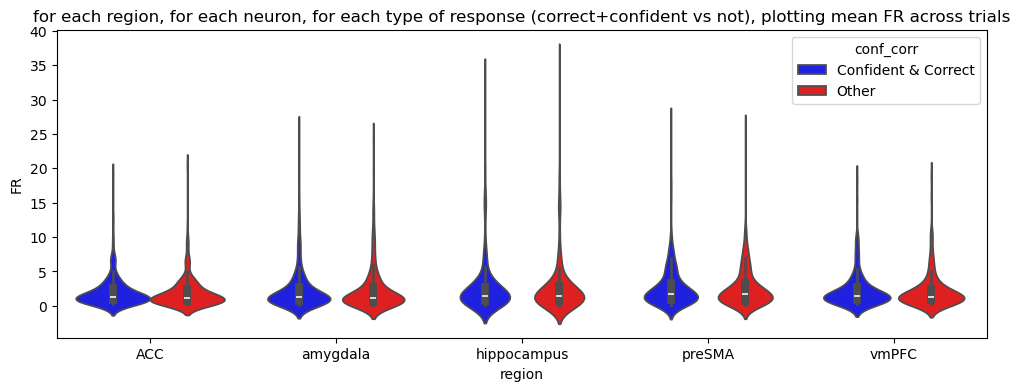

In [8]:
df_recognition['conf_corr'] = df_recognition.apply(lambda row: 'Confident & Correct' if row['response_confidence'] == 3 and row['response_correct'] == 1 else 'Other', axis=1)
print(df_recognition.groupby(['conf_corr']).size())

confidence_correctness_fr = df_recognition.groupby(['region', 'neuron', 'conf_corr'])['FR'].mean().reset_index()
plt.figure(figsize=(12, 4))
sns.violinplot(confidence_correctness_fr, x='region', y='FR', hue='conf_corr', palette=['blue', 'red'])
plt.title('for each region, for each neuron, for each type of response (correct+confident vs not), plotting mean FR across trials')
plt.show()


In [18]:
# convert the label column for confident & correct responses
df_recognition['label'] = df_recognition['conf_corr'].apply(lambda x: 1 if x == 'Confident & Correct' else 0)
# df_recognition['label'] = df_recognition['response_correct'].apply(lambda x: 1 if x == 1.0 else 0)

# Create an empty dictionary to store results by region
results_by_region = {}
regions = df_recognition['region'].unique()

# Loop through each region and train an SVM
for region in regions:
    print(f'Processing region: {region}')
    
    # Filter data for the specific region
    region_data = df_recognition[df_recognition['region'] == region]
    
    # Prepare features (X) and labels (y)
    X = region_data[['FR']]  # You can add more features if available
    y = region_data['label']
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Train the SVM
    svm = SVC(kernel='linear')  # Change kernel if needed
    svm.fit(X_train, y_train)
    
    # Evaluate
    y_pred = svm.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    # Store results in the dictionary
    results_by_region[region] = {
        'confusion_matrix': cm,
        'classification_report': report
    }

# Print results for each region
for region, result in results_by_region.items():
    print(f'\n--- Results for Region: {region} ---')
    print('Confusion Matrix:\n', result['confusion_matrix'])
    print('Classification Report:\n', result['classification_report'])

Processing region: amygdala
Processing region: ACC
Processing region: vmPFC
Processing region: preSMA
Processing region: hippocampus

--- Results for Region: amygdala ---
Confusion Matrix:
 [[   0 1007]
 [   0 3632]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1007
           1       0.78      1.00      0.88      3632

    accuracy                           0.78      4639
   macro avg       0.39      0.50      0.44      4639
weighted avg       0.61      0.78      0.69      4639


--- Results for Region: ACC ---
Confusion Matrix:
 [[   0  695]
 [   0 1447]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       695
           1       0.68      1.00      0.81      1447

    accuracy                           0.68      2142
   macro avg       0.34      0.50      0.40      2142
weighted avg       0.46      0.68      0.54      2142


-